## Data_Preparation_Detect_Destroyed_Villages_Nigeria

describe how I prepared the data

### Libraries

In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 8.8 MB/s 
     |████████████████████████████████| 6.3 MB 46.7 MB/s 
     |████████████████████████████████| 16.7 MB 242 kB/s 


In [18]:
import os
import numpy as np
import pandas as pd
from geopandas import *
import gdal
import random
import json
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

import rasterio
from rasterio.mask import mask

import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.ndimage import rotate
sns.set(color_codes=True)

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")

Tensor Flow Version: 2.8.0
Keras Version: 2.8.0


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper functions

In [20]:
def define_path():
    
    path_base = "/content/drive/MyDrive/Other_Projects/PhD_Detect_Abandoned_Villages"
    path_shp_base = os.path.join(path_base, "Shapefile")
    path_shp = os.path.join(path_shp_base, shp_name+".shp")
    path_tif_base = os.path.join(path_base, "Images")
    path_npy = os.path.join(path_base, "Array")
    
    return path_shp_base, path_shp, path_tif_base, path_npy

def get_POI_before_division(POI, num_types, types):
    # POI_nodiv means POI before dividing into train and test
    POI_nodiv = {}

    for i in range(num_types):

        type_points = types[i]
        POI_nodiv[type_points] = POI[POI[FOI] == type_points]
        print(type_points)
        print(POI_nodiv[type_points].shape)
        
    return POI_nodiv

def get_POI_after_division_train_test(POI, num_types, types, test_division):
    
    POI_nodiv = get_POI_before_division(POI, num_types, types)
    
    POI_div_train_test = {}

    for i in range(num_types):

        type_points = types[i]
        train, test = train_test_split(POI_nodiv[type_points], test_size=test_division, random_state=42, shuffle=True)

        POI_div_train_test[type_points] = [train, test]

        print(type_points, "shape of train, test")
        print(train.shape, test.shape)
        
    return POI_div_train_test

def save_points_for_train_test(POI_div_train_test, num_types, types):
    
    for i in range(num_types):

        type_points = types[i]

        POI_div_train_test[type_points][0].to_file(os.path.join(path_shp_base, type_points[:4]+"_train.shp"))
        POI_div_train_test[type_points][1].to_file(os.path.join(path_shp_base, type_points[:4]+"_test.shp"))
    
    return "Train and Test data saved."

def visualize_points(POI, FOI, title):

    fig, ax = plt.subplots(1, figsize=(6,10))
    ax.set_title(title)
    POI.plot(ax=ax, column=FOI, alpha=1, legend=True)
    
def visualize_train_test_data(POI_div_train_test, num_types, types, FOI):
    
    for i in range(num_types):

        type_points = types[i]
        train = POI_div_train_test[type_points][0]
        test = POI_div_train_test[type_points][1]

        title = type_points+" train"
        visualize_points(train, FOI, title)
        title = type_points+" test"
        visualize_points(test, FOI, title)
        
def get_image(item_name):

    image_name = item_name + ".tif"
    path_image = os.path.join(path_tif_base, image_name)
    image = rasterio.open(path_image)
    
    return image

def reshape_to_expected_size(out_image, expect_size):
    
    # aim: keep the shape of all patches the same by cutting leftover side pixels besides expect size
    # this is functional when expect size is smaller than the shape of real patches, if not, it is not functional
    if out_image.shape[1] != expect_size:

        start = out_image.shape[1] - expect_size
        out_image = out_image[:, start:, :]

        if out_image.shape[2] != expect_size:

            start = out_image.shape[2] - expect_size
            out_image = out_image[:, :, start:]
            
    elif out_image.shape[2] != expect_size:
        
        start = out_image.shape[2] - expect_size
        out_image = out_image[:, :, start:]

    return out_image


# change the dimension of out_image for making training array 
# from (10, 30, 30) to (1, 30, 30, 10)
def change_dimension(out_image, nbands): 
    
    for i in range(nbands):
        # temp is one band of out_image, added dimension used for saving different bands
        temp = np.expand_dims(out_image[i], axis=2)

        if i == 0:
            out_image_new_dim = temp

        else:
            out_image_new_dim = np.concatenate((out_image_new_dim, temp), axis=2)
            
    out_image_new_dim = np.expand_dims(out_image_new_dim, axis=0)

    return out_image_new_dim


def batch_create_datasets_img(img_type_list, buffer_list, types, POI_div_train_test, path_npy):

    data_version = 0

    for i in range(len(img_type_list)):

        img_type = img_type_list[i]
        image = get_image(img_type)

        for j in range(len(buffer_list)):

            buffer_len = buffer_list[j]
            expect_size = int(buffer_len/10)
            shape = (0, expect_size, expect_size, nbands)
            data_version += 1

            for k in range(len(types)):

                type_points = types[k]

                for l in range(len(data_type_list)):

                    shp = POI_div_train_test[type_points][l]
                    data_type = data_type_list[l]
                    array = np.zeros(shape)

                    buffer = shp.buffer(buffer_len)
                    envelope = buffer.envelope  

                    polygons = envelope.geometry
                    polygons = pd.DataFrame(list(polygons))[0]

                    num_features = envelope.shape[0]

                    for m in range(num_features):

                        # get square buffer feature from input shp
                        geo = polygons[m]
                        feature = [geo.__geo_interface__]

                        # cut image from input raster by the square feature
                        out_image, out_transform = mask(image, feature, all_touched=True, crop=True, nodata=image.nodata)

                        # remove the patches with non-data
                        if out_image.min() > 0.0:

                            # reshape the cut image to keep all the sizes of cut images the same
                            out_image_reshape = reshape_to_expected_size(out_image, expect_size)

                            # change the dimension of input cut image for making proper array for training and testing
                            out_image_new_dim = change_dimension(out_image_reshape, nbands)

                            array = np.concatenate((array, out_image_new_dim), axis=0)

                            array_name = "dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len)+"_"+type_points[:4]+"_"+data_type+"_img.npy"
                            array_path = os.path.join(path_npy, array_name)

                            np.save(array_path, array)
                            
                    print("Done", array_name)
    
    return "All datasets have been created."

def load_array(path_npy, data_version, img_type, buffer_len, type_points, data_type):
                    
    array_name = "dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len)+"_"+type_points[:4]+"_"+data_type+"_img.npy"
    array_name = os.path.join(path_npy, array_name)
    array = np.load(array_name)

    return array

def save_final_image_array(array, path_npy, data_version, img_type, buffer_len, data_type):
                    
    array_name = "dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len)+"_"+data_type+"_img.npy"
    array_path = os.path.join(path_npy, "Final", array_name)
    np.save(array_path, array)
    
def save_final_label_array(label_list, data_version, img_type, buffer_len, merge_type, data_type, path_npy):
    
    label_array = np.array(label_list)
    label_name = "dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len)+"_"+data_type+"_"+merge_type+"_lab.npy"
    label_path = os.path.join(path_npy, "Final", label_name)
    np.save(label_path, label_array)

def batch_create_datasets_final_img_lab(img_type_list, buffer_list, types, merge_type_list, path_npy):

    data_version = 0

    for i in range(len(img_type_list)):

        img_type = img_type_list[i]

        for j in range(len(buffer_list)):

            buffer_len = buffer_list[j]
            data_version += 1

            for k in range(len(data_type_list)):

                data_type = data_type_list[k]

                destroyed_array = load_array(path_npy, data_version, img_type, buffer_len, types[0], data_type)
                partfunct_array = load_array(path_npy, data_version, img_type, buffer_len, types[1], data_type)
                fullfunct_array = load_array(path_npy, data_version, img_type, buffer_len, types[2], data_type)

                image_array = np.concatenate((destroyed_array, partfunct_array, fullfunct_array), axis=0)
                save_final_image_array(image_array, path_npy, data_version, img_type, buffer_len, data_type)

                destroyed_label = [1 for i in range(destroyed_array.shape[0])]
                partfunct_label_0 = [0 for i in range(partfunct_array.shape[0])]
                partfunct_label_1 = [1 for i in range(partfunct_array.shape[0])]
                fullfunct_label = [0 for i in range(fullfunct_array.shape[0])]

                merge_type = merge_type_list[0]

                label_list = destroyed_label + partfunct_label_0 + fullfunct_label
                save_final_label_array(label_list, data_version, img_type, buffer_len, merge_type, data_type, path_npy)

                merge_type = merge_type_list[1]

                label_list = destroyed_label + partfunct_label_1 + fullfunct_label
                save_final_label_array(label_list, data_version, img_type, buffer_len, merge_type, data_type, path_npy)

                print("dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len))
                print(data_type)
                print(types[0], destroyed_array.shape)
                print(types[1], partfunct_array.shape)
                print(types[2], fullfunct_array.shape)
                print("")

## Main

#### 1. Set the global variables and paths

In [21]:
nbands = 3

# set the information of points of interest
shp_name = "All"

# field of interest: the status of destroyed or funcitonal
FOI = "FUN"

# 80% of points under each type for training and validation and the 20% for testing
test_division = 0.2

# define the path of shapefiles and image files
path_shp_base, path_shp, path_tif_base, path_npy = define_path()

#### 2. Divide point data into train & validation and test subsets
1. read points data as "POI"
2. get the attributes of field of interest and save them in "types"
3. visualize the spatial distribution of all points
4. divide the points into different types and save it in "POI_nodiv" before dividing it into train and test
5. divide the points into train and test based on different types and save it in "POI_div_train_test" (a dict, [train,test])
6. save the divided points as shapefile
7. visualize the spatial distribution of train and test points


['Destroyed', 'Partially Functional', 'Fully Functional']


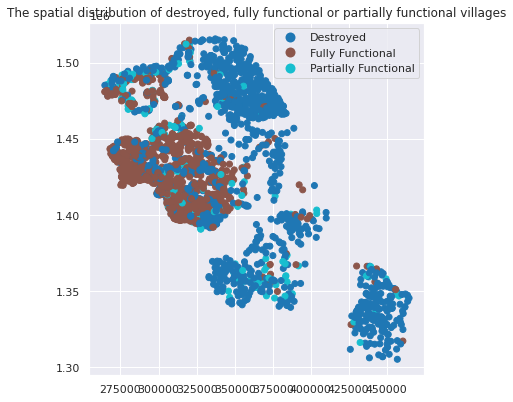

In [22]:
# load point data and check the types of status of villages
# points of interest is a geo-dataframe
POI = geopandas.read_file(path_shp)
types = list(POI[FOI].unique())
num_types = len(types)
print(types)

# visualize points
title = "The spatial distribution of destroyed, fully functional or partially functional villages"
visualize_points(POI, FOI, title)

Destroyed
(1170, 11)
Partially Functional
(170, 11)
Fully Functional
(1261, 11)
Destroyed shape of train, test
(936, 11) (234, 11)
Partially Functional shape of train, test
(136, 11) (34, 11)
Fully Functional shape of train, test
(1008, 11) (253, 11)


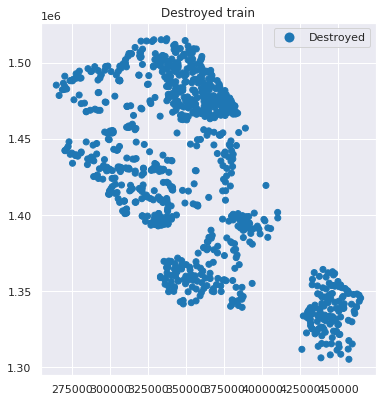

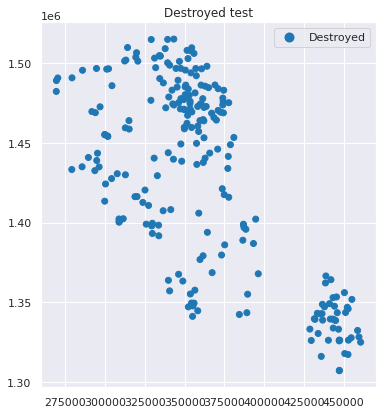

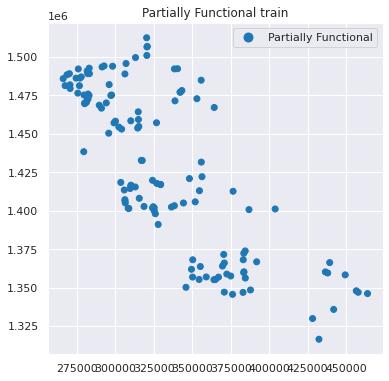

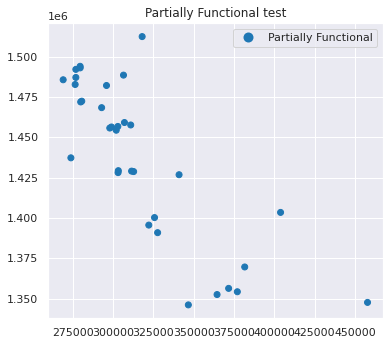

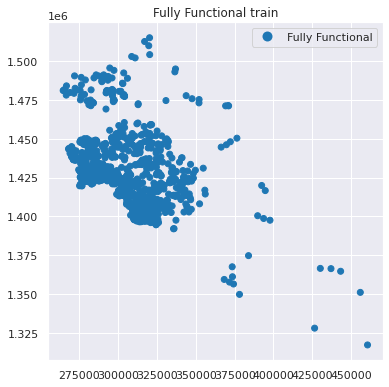

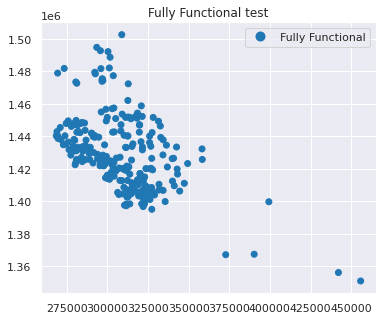

In [23]:
# split points for training & validation,testing
# POI_div_train_test means POI after dividing into train and test randomly
# [train, test]
# POI_div_train_test is important as the setting of train&validation and test
POI_div_train_test = get_POI_after_division_train_test(POI, num_types, types, test_division)

# save the points for train or test of three types as shapefile
save_points_for_train_test(POI_div_train_test, num_types, types)

# visualize the spatial distribution of all datasets of points
visualize_train_test_data(POI_div_train_test, num_types, types, FOI)

#### 3. Get the Numpy Array for different datasets
1. read the input image
2. define buffer length
3. define types of status 
4. define train or test
5. based on 3,4, read point shapefile
6. create buffer zones based on the point shapefile and buffer length
7. read each polygon from created buffer zones and get the image array from the input image
8. reshape the image array and change the dimension of it and delete arrays with nan values (less than 0)
9. repeat step 7 and 8, get the cleaned and reshaped array of one dataset
10. save the dataset in the path_npy
11. repeat the step 1 to 9, get all datasets

In [52]:
# set the type of images
img_type_list = ["NDVI", "PCA"]

# define the length of square buffer
buffer_list = [300]

# dataset types
data_type_list = ["train", "test"]

In [53]:
# create datasets for images
batch_create_datasets_img(img_type_list, buffer_list, types, POI_div_train_test, path_npy)

Done dataset_1_NDVI_Buf300_Dest_train_img.npy
Done dataset_1_NDVI_Buf300_Dest_test_img.npy
Done dataset_1_NDVI_Buf300_Part_train_img.npy
Done dataset_1_NDVI_Buf300_Part_test_img.npy
Done dataset_1_NDVI_Buf300_Full_train_img.npy
Done dataset_1_NDVI_Buf300_Full_test_img.npy
Done dataset_2_PCA_Buf300_Dest_train_img.npy
Done dataset_2_PCA_Buf300_Dest_test_img.npy
Done dataset_2_PCA_Buf300_Part_train_img.npy
Done dataset_2_PCA_Buf300_Part_test_img.npy
Done dataset_2_PCA_Buf300_Full_train_img.npy
Done dataset_2_PCA_Buf300_Full_test_img.npy


'All datasets have been created.'

In [41]:
patch.shape, patch_mean.shape

((922, 80, 80, 3), (80, 80, 3))

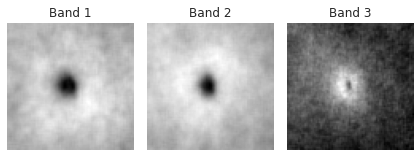

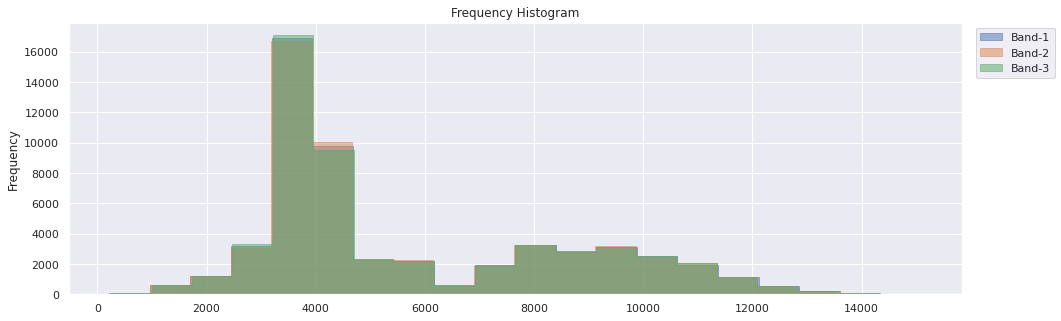

In [95]:
# visualize the histogram of each area under each type (average), totally, 15 histograms
patch_name = "test_func_PCA_Buf400_img.npy"
patch_path = os.path.join(path_npy, patch_name)
patch = np.load(patch_path)

rows, cols = 1, 3
nbands_start = 0
nbands_end = 3
        
patch_mean = np.mean(patch, axis=0)
#patch_mean = patch[11]

# display each band
display_multiple_ndvi(patch_mean, nbands, rows, cols)

# display histgram of each band
display_multiple_hist_basic(patch, nbands_start, nbands_end, rows, cols)
plt.pause(0.5)

In [56]:
def display_multiple_img(patch, nbands, rows, cols):
    
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    
    for i in range(nbands):
        
        title = "Band " + str(i+1) 
        ax.ravel()[i].imshow(patch[:,:,i], cmap=plt.cm.Greys)
        ax.ravel()[i].set_title(title)
        ax.ravel()[i].set_axis_off()
        
    plt.grid(False)         
    plt.tight_layout()
    plt.show()
    

def display_multiple_ndvi(patch, nbands, rows, cols):
    
    figure, axs = plt.subplots(nrows=rows, ncols=cols)
    
    for i, ax in enumerate(axs.flatten()):
        
        title = "Band " + str(i+1) 
        plt.sca(ax)
        plt.imshow(patch[:, :, i], cmap="gray")
        plt.axis("off")
        plt.grid(False)
        plt.title(title)
                
    plt.tight_layout()
    plt.show()
    
    
def display_multiple_hist_basic(patch, nbands_start, nbands_end, rows, cols):
    
    # setting
    kwargs = dict(alpha=0.5, bins=20, density=False, stacked=True, fill=True, histtype='step')
    plt.figure(figsize=(16,5)) 

    for i in range(nbands_start, nbands_end):
        x =  patch[:,:,i].flatten()
        plt.hist(x, **kwargs, label='Band-'+str(i+1));

    plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');  
    
    
def display_multiple_hist_three_types(patch, nbands, rows, cols):
    
    # for original s2 images, there are too many bands, 10, making it hard to read the histogram
    # so here has three types of histogram, all, first half, second half
    nbands_start = 0
    nbands_end = nbands
    display_multiple_hist_basic(patch, nbands_start, nbands_end, rows, cols)
    
    nbands_start = 0
    nbands_end = int(nbands/2)
    display_multiple_hist_basic(patch, nbands_start, nbands_end, rows, cols)
    
    nbands_start = int(nbands/2)
    nbands_end = nbands
    display_multiple_hist_basic(patch, nbands_start, nbands_end, rows, cols)

#### 4. Combine datasets for final train and test

In [ ]:
# merge type
# partfull: merge partially functional and fully functional together
# partdest: merge partially functional and destroyed together
merge_type_list = ["partfull", "partdest"]

In [ ]:
batch_create_datasets_final_img_lab(img_type_list, buffer_list, types, merge_type_list, path_npy)

dataset_1_NDVI_Buf320
train
Destroyed (888, 32, 32, 3)
Partially Functional (130, 32, 32, 3)
Fully Functional (975, 32, 32, 3)

dataset_1_NDVI_Buf320
test
Destroyed (224, 32, 32, 3)
Partially Functional (32, 32, 32, 3)
Fully Functional (248, 32, 32, 3)

dataset_2_NDVI_Buf480
train
Destroyed (874, 48, 48, 3)
Partially Functional (126, 48, 48, 3)
Fully Functional (956, 48, 48, 3)

dataset_2_NDVI_Buf480
test
Destroyed (216, 48, 48, 3)
Partially Functional (32, 48, 48, 3)
Fully Functional (241, 48, 48, 3)

dataset_3_NDVI_Buf640
train
Destroyed (860, 64, 64, 3)
Partially Functional (123, 64, 64, 3)
Fully Functional (942, 64, 64, 3)

dataset_3_NDVI_Buf640
test
Destroyed (211, 64, 64, 3)
Partially Functional (29, 64, 64, 3)
Fully Functional (240, 64, 64, 3)

dataset_4_PCA_Buf320
train
Destroyed (880, 32, 32, 3)
Partially Functional (130, 32, 32, 3)
Fully Functional (972, 32, 32, 3)

dataset_4_PCA_Buf320
test
Destroyed (219, 32, 32, 3)
Partially Functional (32, 32, 32, 3)
Fully Functional (248

## Data Augmentation


In [ ]:
def define_path(path):
    
    path_base = path
    path_array = os.path.join(path_base, "InputData")
    path_array_DA = os.path.join(path_array, "DA")
    
    return path_base, path_array, path_array_DA

def get_array(data_version, img_type, buffer_len, path_npy, train_test, img_lab):
    
    name_array = "dataset_"+str(data_version)+"_"+img_type+"_Buf"+str(buffer_len)+"_"+train_test+"_"+img_lab+".npy"
    path_array = os.path.join(path_npy, name_array)
    array = np.load(path_array)
    
    return array

def rescale_array_to_255_int(arr):

    new_arr = ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')
    return new_arr

def show_histgram(img):
    plt.figure(figsize=(5, 5), dpi=100)
    sns.distplot(img[:, :, 0].flatten(), color='maroon')
    sns.distplot(img[:, :, 1].flatten(), color='green')
    sns.distplot(img[:, :, 2].flatten(), color='blue').set_title('RGB Distribution')

def show_img(img, ax):
    img = rescale_array_to_255_int(img)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img)

def plot_grid(imgs, nrows, ncols, figsize=(10, 10)):
    assert len(imgs) == nrows*ncols, f"Number of images should be {nrows}x{ncols}"
    img = rescale_array_to_255_int(img)
    _, axs = plt.subplots(nrows, ncols, figsize=figsize)
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        show_img(img, ax)

def translate(img, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    img = rescale_array_to_255_int(img)
    if direction == 'right':
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 'left':
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 'down':
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 'up':
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img

def rotate_img(img, angle, bg_patch=(5,5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

def get_new_data_by_rotate(imgset, rotate_angle):
    
    num_img = imgset.shape[0]
    shape = (0, height, width, channels)
    imgset_new = np.zeros(shape)

    for i in range(num_img):

        img = imgset[i]
        img_new = rotate_img(img, rotate_angle, bg_patch=(5,5))
        img_new = np.expand_dims(img_new, axis=0)
        imgset_new = np.concatenate((imgset_new, img_new), axis=0)
    
    return imgset_new

def get_new_data_by_translate(imgset, shift_pixel, direction):
    
    num_img = imgset.shape[0]
    shape = (0, height, width, channels)
    imgset_new = np.zeros(shape)

    for i in range(num_img):

        img = imgset[i]
        img_new = translate(img, shift=shift_pixel, direction=direction, roll=True)
        img_new = np.expand_dims(img_new, axis=0)
        imgset_new = np.concatenate((imgset_new, img_new), axis=0)
    
    return imgset_new

def merge_image_sets(original_imgset, new_img_list):

    for i in range(len(new_img_list)):
        original_imgset = np. concatenate((original_imgset, new_img_list[i]), axis=0)

    return original_imgset


def create_new_label_sets(original_labset, number_new_imgsets):

    new_labset = original_labset
    for i in range(number_new_imgsets):
        new_labset = np.concatenate((new_labset, original_labset), axis=0)
    
    return new_labset

def save_new_DA_data(path_npy_DA, new_img, new_lab_partfull, new_lab_partdest, DA_type):
    new_img_name = "dataset_DA_Ori_"+DA_type+"_train_img.npy"
    new_lab_partfull_name = "dataset_DA_Ori_"+DA_type+"_train_partfull_lab.npy"
    new_lab_partdest_name = "dataset_DA_Ori_"+DA_type+"_train_partdest_lab.npy"

    new_img_path = os.path.join(path_npy_DA, new_img_name)
    new_lab_partfull_path = os.path.join(path_npy_DA, new_lab_partfull_name)
    new_lab_partdest_path = os.path.join(path_npy_DA, new_lab_partdest_name)

    np.save(new_img_path, new_img)
    np.save(new_lab_partfull_path, new_lab_partfull)
    np.save(new_lab_partdest_path, new_lab_partdest)

In [ ]:
# define important variables
# define the path
path_base, path_npy, path_npy_DA = define_path(path)

# the train img performs best under the setting, fc=24, bs=256, pca, buffer=640
data_version = 7
img_type = "PCA"
buffer_len = 640
n_fc = 24
bs = 256
nbands = 3
height, width, channels = int(buffer_len/10), int(buffer_len/10), nbands

In [ ]:
# load array of interest (performs highest accuracies)
train_test = "train"

train_img = get_array(data_version, img_type, buffer_len, path_npy, train_test, "img")
train_lab_partfull = get_array(data_version, img_type, buffer_len, path_npy, train_test, "partfull_lab")
train_lab_partdest = get_array(data_version, img_type, buffer_len, path_npy, train_test, "partdest_lab")

train_img.shape, train_lab_partfull.shape, train_lab_partdest.shape 

((1895, 64, 64, 3), (1895,), (1895,))

In [ ]:
# create new data by rotate or translate original data
rotate_angle = 60
train_img_rotate =  get_new_data_by_rotate(train_img, rotate_angle)

shift_pixel = 16
direction = "left"
train_img_translate = get_new_data_by_translate(train_img, shift_pixel, direction)

In [ ]:
# merge original data and new created data - rotate
new_img_list = [train_img_rotate]
new_train_img = merge_image_sets(train_img, new_img_list)

number_new_imgsets = len(new_img_list)
new_train_lab_partfull = create_new_label_sets(train_lab_partfull, number_new_imgsets)

number_new_imgsets = len(new_img_list)
new_train_lab_partdest = create_new_label_sets(train_lab_partdest, number_new_imgsets)

print(new_train_img.shape, new_train_lab_partfull.shape, new_train_lab_partdest.shape)

# save augmented data
DA_type = "rotate_"+str(rotate_angle)
save_new_DA_data(path_npy_DA, new_train_img, new_train_lab_partfull, new_train_lab_partdest, DA_type)

(3790, 64, 64, 3) (3790,) (3790,)


In [ ]:
# merge original data and new created data - translate
new_img_list = [train_img_translate]
new_train_img = merge_image_sets(train_img, new_img_list)

number_new_imgsets = len(new_img_list)
new_train_lab_partfull = create_new_label_sets(train_lab_partfull, number_new_imgsets)

number_new_imgsets = len(new_img_list)
new_train_lab_partdest = create_new_label_sets(train_lab_partdest, number_new_imgsets)

print(new_train_img.shape, new_train_lab_partfull.shape, new_train_lab_partdest.shape)

# save augmented data
DA_type = "translate_"+direction+"_"+str(shift_pixel)
save_new_DA_data(path_npy_DA, new_train_img, new_train_lab_partfull, new_train_lab_partdest, DA_type)

(3790, 64, 64, 3) (3790,) (3790,)


In [ ]:
# merge original data and new created data - rotate and translate
new_img_list = [train_img_rotate, train_img_translate]
new_train_img = merge_image_sets(train_img, new_img_list)

number_new_imgsets = len(new_img_list)
new_train_lab_partfull = create_new_label_sets(train_lab_partfull, number_new_imgsets)

number_new_imgsets = len(new_img_list)
new_train_lab_partdest = create_new_label_sets(train_lab_partdest, number_new_imgsets)

print(new_train_img.shape, new_train_lab_partfull.shape, new_train_lab_partdest.shape)

# save augmented data
DA_type = "rotate_"+str(rotate_angle)+"_translate_"+direction+"_"+str(shift_pixel)
save_new_DA_data(path_npy_DA, new_train_img, new_train_lab_partfull, new_train_lab_partdest, DA_type)

(5685, 64, 64, 3) (5685,) (5685,)
